# riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1. Initiation Ginnette files

In [37]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array

libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/mini-LOMOS/GINETTE_SENSI/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=30*7
date_simul_bg=pd.to_datetime("2022-05-01 14:00:00")
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=-1
ost=0
# size columnin meter
z_top=-0.1
z_bottom=-0.4
az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01

# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=2
#cote de la limitein meter, if you want more layer just add a new line
alt_thk=-0.25

# number of cell
nb_cell=az/dz

# porosity
REF_n=0.38 # \omega
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]
REF_k=3.33333333333333e-12
# solid grain density rho_s=val_r  [kg.m-3]
REF_r=1600


# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# 1.5 e+6 4e+6
#rho_m imposed : 1000
# high slow
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 
REF_c=2650
REF_l=8 #

if nb_zone==2:
    # zone 1
    # porosity
    REF_n=0.10 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k=6e-11
    # Heat capacity
    REF_r=2500
    #lambda
    REF_l=8
    # zone 2
    # porosity
    REF_n2=0.05 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
    REF_k2=6e-15
    # solid grain density rho_s=val_r  [kg.m-3]
    REF_r2=2600
    REF_l2=3

print("la simulation commence à",date_simul_bg)
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.2e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.2e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)
print(az,z_bottom,z_top)
#Observation positions x 0.50000
#Observation in meter
Obs1=z_top
Obs2=z_top-0.1
Obs3=z_top-0.2
Obs4=z_top-0.3


## write the parameters

cell1=abs((z_top-Obs1)/dz)+1
cell2=abs((z_top-Obs2)/dz)
cell3=abs((z_top-Obs3)/dz)
cell4=abs((z_top-Obs4)/dz)
print(cell1,z_top,Obs1)

setup_model=setup_model.replace('[cell1]','%05d' % cell1)
setup_model=setup_model.replace('[cell2]','%05d' % cell2)
setup_model=setup_model.replace('[cell3]','%05d' % cell3)
setup_model=setup_model.replace('[cell4]','%05d' % cell4)

f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()






Current working directory: /home/ariviere/Programmes/ginette/application/mini-LOMOS/GINETTE_SENSI
ginette exist
la simulation commence à 2022-05-01 14:00:00
0.30000000000000004 -0.4 -0.1
1.0 -0.1 -0.1


# 2. Read observation data

In [38]:
# Définissez le répertoire où se trouvent les fichiers CSV
Obs_data = '../OBS_point/signy-amont/'
# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(Obs_data)

info = None
all_data = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'info' in fichier:
            info = pd.read_csv(os.path.join(Obs_data, fichier))
        elif 'dP' in fichier:
            all_data = pd.read_csv(os.path.join(Obs_data, fichier))
all_data['dates']=pd.to_datetime(all_data['dates'],format='%Y-%m-%d %H:%M:%S')
all_data=all_data[all_data['dates']>=date_simul_bg]
# Réindexer le DataFrame
all_data.reset_index(drop=True, inplace=True)
all_data['deltaP']=all_data['deltaP']*coef+ost


date_begin= all_data['dates'].iloc[0]
date_end = pd.to_datetime(date_begin) + pd.to_timedelta(nb_day, unit='d')
print(date_begin,date_end)
# pas de temps
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

# pas de temps=900s
is_equal_900_sec = all(time_diff == pd.Timedelta(seconds=900))

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])
all_data['dates']

2022-05-01 14:00:00 2022-11-27 14:00:00
Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :
Index([7670, 13210, 20981], dtype='int64')
                    dates    VMolo    deltaP  TempMolo   Temp1   Temp2  \
7670  2022-07-20 14:06:21  1.27306  0.025912    23.901  23.970  23.546   
13210 2022-09-16 11:20:03  1.20228 -0.028065    16.726  16.769  16.790   
20981 2022-12-06 13:00:00  2.49996  1.281547     5.622   5.647   6.199   

        Temp3   Temp4  
7670   22.905  22.702  
13210  16.732  16.755  
20981   6.908   7.503  


0       2022-05-01 14:00:00
1       2022-05-01 14:15:00
2       2022-05-01 14:30:00
3       2022-05-01 14:45:00
4       2022-05-01 15:00:00
                ...        
39212   2023-06-14 10:45:00
39213   2023-06-14 11:00:00
39214   2023-06-14 11:15:00
39215   2023-06-14 11:30:00
39216   2023-06-14 11:45:00
Name: dates, Length: 39217, dtype: datetime64[ns]

In [39]:
# Trouver les horodatages qui ne commencent pas à des intervalles de 15 minutes et ajuster uniquement ceux-là
#mask = all_data['dates'].dt.minute % 15 != 0
#all_data.loc[mask, 'timestamps'] = all_data.loc[mask, 'dates'] - pd.to_timedelta(all_data.loc[mask, 'dates'].dt.minute % 15, unit='m')
# Réinitialiser les secondes à zéro pour tous les horodatages
all_data['dates'] = all_data['dates'].dt.floor('min')
all_data['dates'] = all_data['dates'].dt.floor('15T')


In [40]:

all_data['timestamps']=all_data['dates']

# Créez un nouvel index avec des dates toutes les 15 minutes
new_index = pd.date_range(start=all_data['timestamps'].min(), end=all_data['timestamps'].max(), freq='15T')

# Réindexez le DataFrame pour inclure ces nouvelles dates
all_data = all_data.set_index('timestamps').reindex(new_index)
# Sélection des colonnes pour l'interpolation
columns_to_interpolate = ['deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Appliquez l'interpolation uniquement sur la colonne 'valeur'
all_data[columns_to_interpolate] = all_data[columns_to_interpolate].interpolate(method='time')

print(all_data['dates'].iloc[0],all_data['dates'].iloc[-1])


2022-05-01 14:00:00 2023-06-14 11:45:00


In [41]:

# Vérification des écarts temporels après l'interpolation
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])

Toutes les différences entre les lignes sont de 900 secondes.


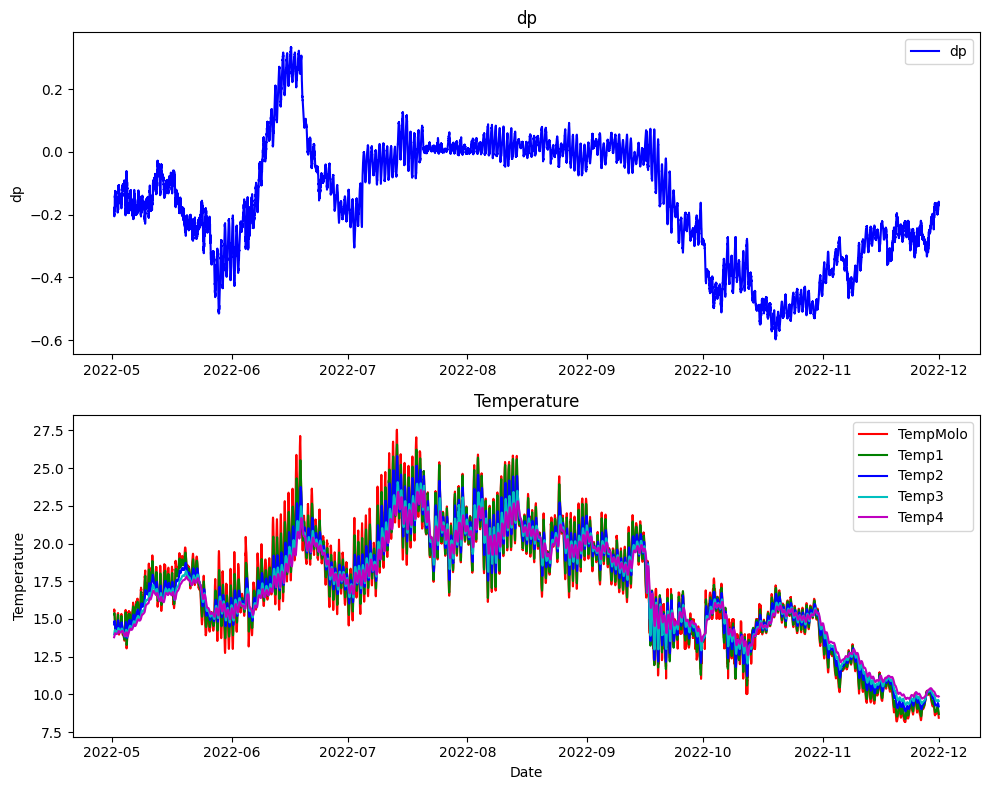

In [42]:
all_data= all_data[ (all_data['dates'] < '2022-12-01')]
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(all_data['dates'], all_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(all_data['dates'], all_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Zoom temperature



In [43]:
filtered_data = all_data[(all_data['dates'] > '2022-10-01') & (all_data['dates'] < '2022-10-16')]


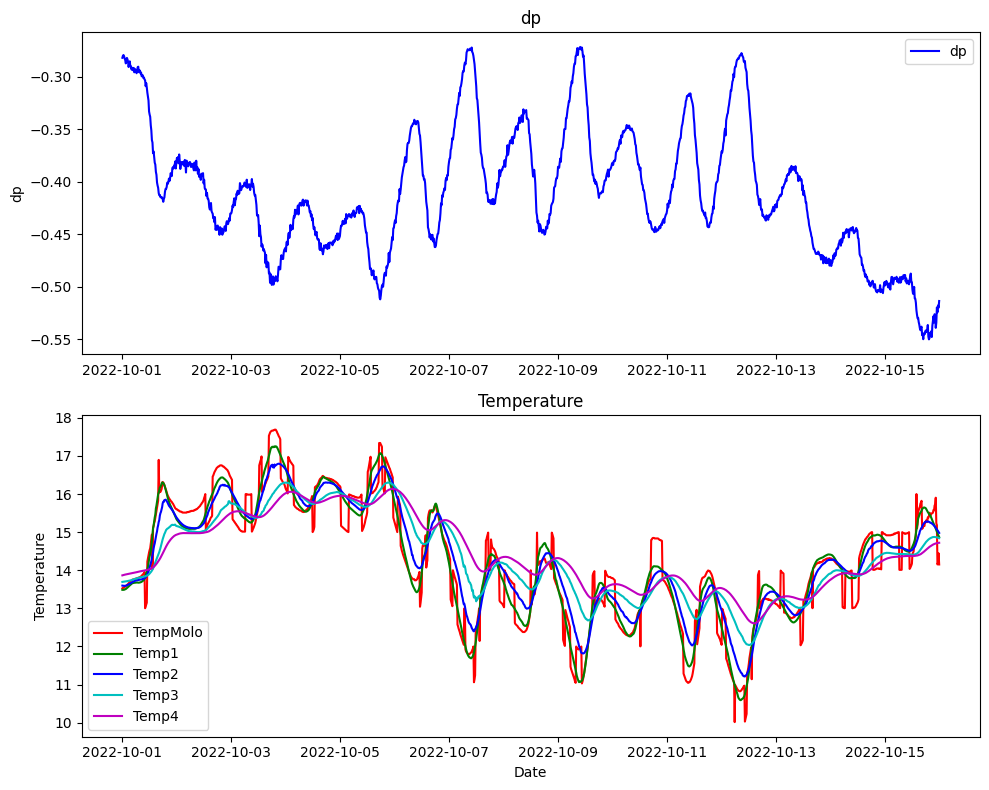

In [44]:
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(filtered_data['dates'],filtered_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(filtered_data['dates'], filtered_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()



## 2. Reference simulation and sampling



In [45]:
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')
f_paramZ_bck=open("E_zone_parameter_backup.dat", "r")
f_paramZ_new = open("E_zone_parameter.dat", 'w')

param_zone=f_paramZ_bck.read()
coord=pd.DataFrame()    

# replace the parameter values
param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)

if nb_zone ==2 :
    f_param_bck.close()
    f_paramZ_bck=open("E_zone_parameter_backup_2zones.dat","r")
    param_zone=f_paramZ_bck.read()
    param_zone=param_zone.replace('[k1]','%8.2e' % REF_k)
    param_zone=param_zone.replace('[n1]','%6.2f' % REF_n)
    param_zone=param_zone.replace('[l1]','%6.2f' % REF_l)
    param_zone=param_zone.replace('[r1]','%6.2f' % REF_r)
    param_zone=param_zone.replace('[k2]','%8.2e' % REF_k2)
    param_zone=param_zone.replace('[n2]','%6.2f' % REF_n2)
    param_zone=param_zone.replace('[l2]','%6.2f' % REF_l2)
    param_zone=param_zone.replace('[r2]','%6.2f' % REF_r2)
                      
    
# Coodrinate  
zvalues =  np.sort(np.arange(z_bottom+dz/2,dz/2,dz ))

xvalues = np.array([0.5])
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1


#Pour plusieurs zones modification AR
if nb_zone >= 2:
        coord['zone'] = np.where(coord['z'] >= alt_thk, 2,coord['zone'])
#Write new ginette files
f_paramZ_new.write(param_zone)

coord.zone.to_csv(f_zone, index = False, header=False)

# close files    
f_zone.close()
f_coor.close()
f_paramZ_new.close()
f_paramZ_bck.close()






# Inital conditions
f_temp_IC=open("E_temperature_initiale.dat","w")
initial_temps = all_data.iloc[0][['Temp1', 'Temp2', 'Temp3', 'Temp4']]
z_temps = np.array([-0.1, -0.2, -0.3, -0.4])
initial = pd.DataFrame({'z': z_temps, 'T': initial_temps})
initial['z'] = initial['z'].astype(float)
initial['T'] = initial['T'].astype(float)


# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005

# Perform linear interpolation
Temp_init = np.interp(z_values, initial['z'][::-1], initial['T'][::-1])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_temp = {
    'z': z_values,
    'T': Temp_init
}

interpolated_temp = pd.DataFrame(interpolated_temp)
interpolated_temp_sorted = interpolated_temp.sort_values(by='z', ascending=False)

interpolated_temp_sorted['T'].to_csv(f_temp_IC, index = False, sep='\n', header=False)

# To apply dp to the column, we need to convert it to a pressure value
f_chg_IC=open("E_charge_initiale.dat","w")
initial_pres = all_data.iloc[0][['deltaP']]*-1
initial_chg = pd.DataFrame({'z': z_bottom, 'chg': [0]})
new_row = pd.DataFrame({'z': z_top, 'chg':initial_pres})
initial_chg = pd.concat([initial_chg, new_row], ignore_index=True)
initial_chg['z'] = initial_chg['z'].astype(float)
initial_chg['chg'] = initial_chg['chg'].astype(float)
# Define the range of depths for interpolation
dz_bot=z_bottom+dz/2
dz_top=z_top+0.001
z_values = np.arange(dz_bot, 0.001, dz)  # Depth range from -0.4 to 0.005


# Perform linear interpolation
charge_init = np.interp(z_values, initial_chg['z'][:], initial_chg['chg'][:])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_chg = {
    'z': z_values,
    'chg': charge_init
}
interpolated_chg = pd.DataFrame(interpolated_chg)
interpolated_chg_sorted = interpolated_chg.sort_values(by='z', ascending=False)



interpolated_chg_sorted['chg'].to_csv(f_chg_IC, index = False, sep='\n', header=False)

f_chg_IC.close()
f_temp_IC.close()

In [46]:


# Boundary conditions
all_data['bot']=0
all_data['top']=all_data['deltaP']*-1
all_data[['top','bot']].to_csv('E_charge_t.dat', sep=' ', index=False, header=False)
all_data[['Temp1', 'Temp4']].to_csv('E_temp_t.dat', sep=' ', index=False, header=False)





In [47]:
# run ginette
subprocess.call(["./ginette"])

0

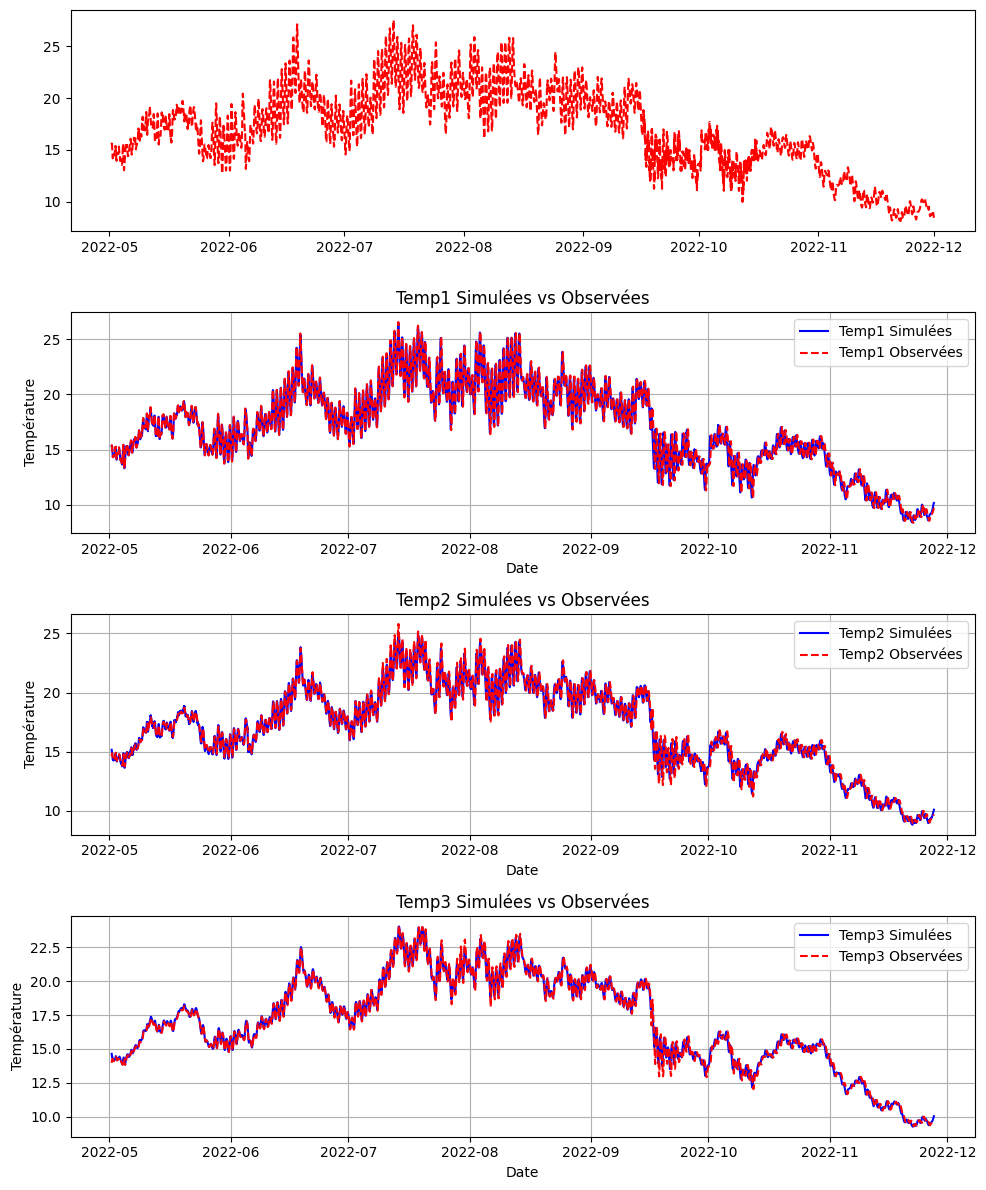

In [48]:
# Colonnes pour les températures
column_names = ['Temp_1', 'Temp_2', 'Temp_3']

# Liste pour stocker les DataFrames
all_dfs = []
# Lire et stocker les DataFrames
for i in range(1,4 ):
    file_path = f'Sim_temperature_maille{i}_t.dat'
    df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
    all_dfs.append(df)

# Fusionner les DataFrames sur la colonne 'Time'
sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

for df in all_dfs[1:]:
    sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

# Trier les colonnes par ordre numérique
sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

obs_temp = all_data[all_data['dates'] < date_end]
# Tracer les températures simulées et observées pour chaque température
fig, axs = plt.subplots(4, 1, figsize=(10, 12))
axs[0].plot(all_data['dates'], all_data['TempMolo'], label='TempMolo Observées', linestyle='--', color='red')
# Tracer les températures simulées (sim_temp)
for i in range(1, 4):
    axs[i].plot(sim_temp['dates'], sim_temp[f'Temp{i}'], label=f'Temp{i} Simulées', linestyle='-', color='blue')

# Tracer les températures observées (sim_obs)
  
for i in range(1, 4):
    axs[i].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], label=f'Temp{i} Observées', linestyle='--', color='red')

    # Configurations supplémentaires pour chaque subplot
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Température')
    axs[i].set_title(f'Temp{i} Simulées vs Observées')
    axs[i].legend()
    axs[i].grid(True)

# Afficher les subplots
plt.tight_layout()
plt.show()



## Zoom resultats

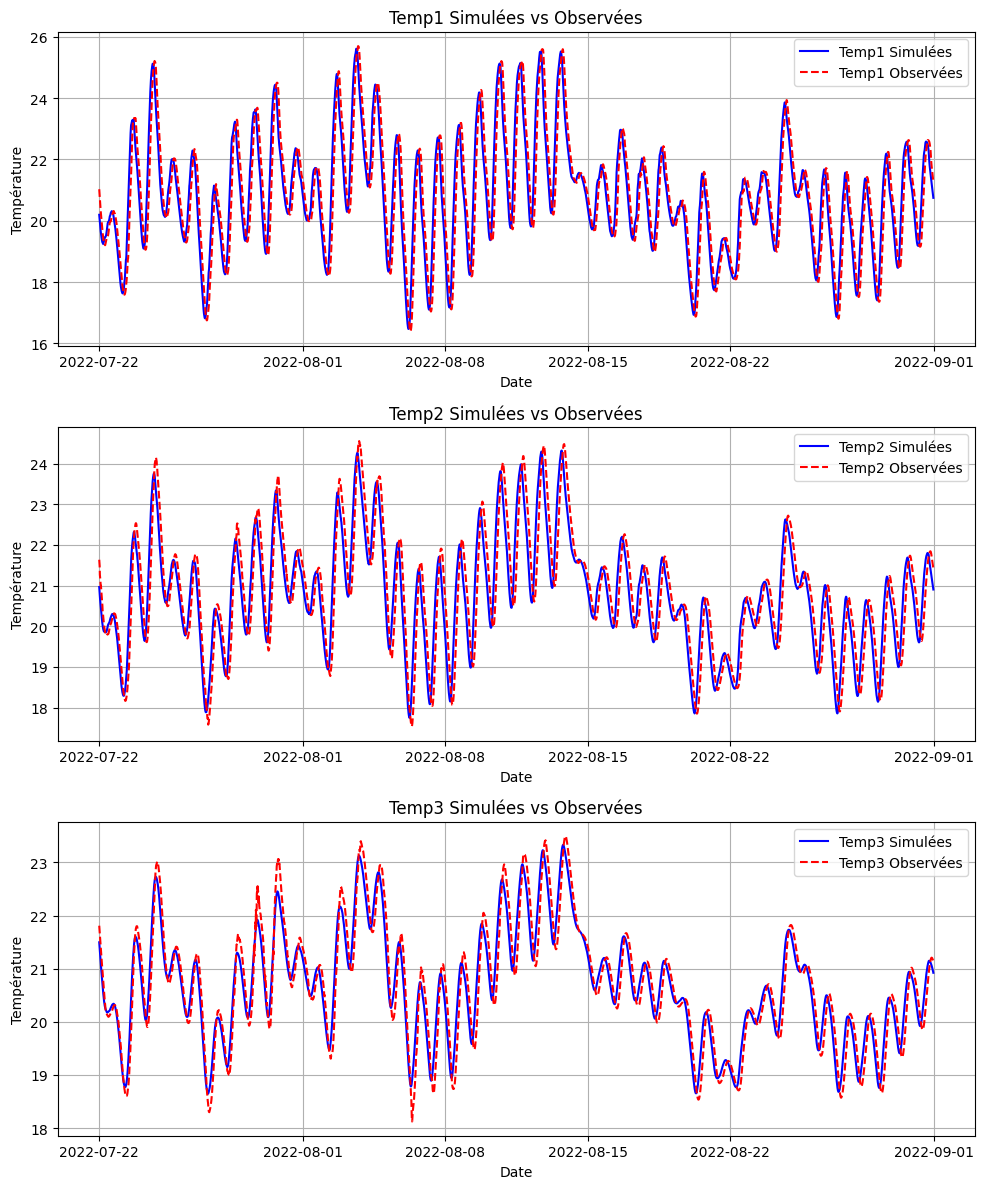

In [49]:
obs_temp = all_data[(all_data['dates'] > '2022-07-22')&(all_data['dates'] < '2022-09-01')]
sim_temp_z = sim_temp[(sim_temp['dates'] > '2022-07-22') & (sim_temp['dates'] < '2022-09-01')]

# Tracer les températures simulées et observées pour chaque température
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Tracer les températures simulées (sim_temp)
for i in range(1, 4):
    axs[i - 1].plot(sim_temp_z['dates'], sim_temp_z[f'Temp{i}'], label=f'Temp{i} Simulées', linestyle='-', color='blue')

# Tracer les températures observées (sim_obs)
for i in range(1, 4):
    axs[i - 1].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], label=f'Temp{i} Observées', linestyle='--', color='red')

    # Configurations supplémentairobes pour chaque subplot
    axs[i - 1].set_xlabel('Date')
    axs[i - 1].set_ylabel('Température')
    axs[i - 1].set_title(f'Temp{i} Simulées vs Observées')
    axs[i - 1].legend()
    axs[i - 1].grid(True)

# Afficher les subplots
plt.tight_layout()

# Save the plot to a file (e.g., PNG format)
plt.savefig('my_plot.png')
plt.show()

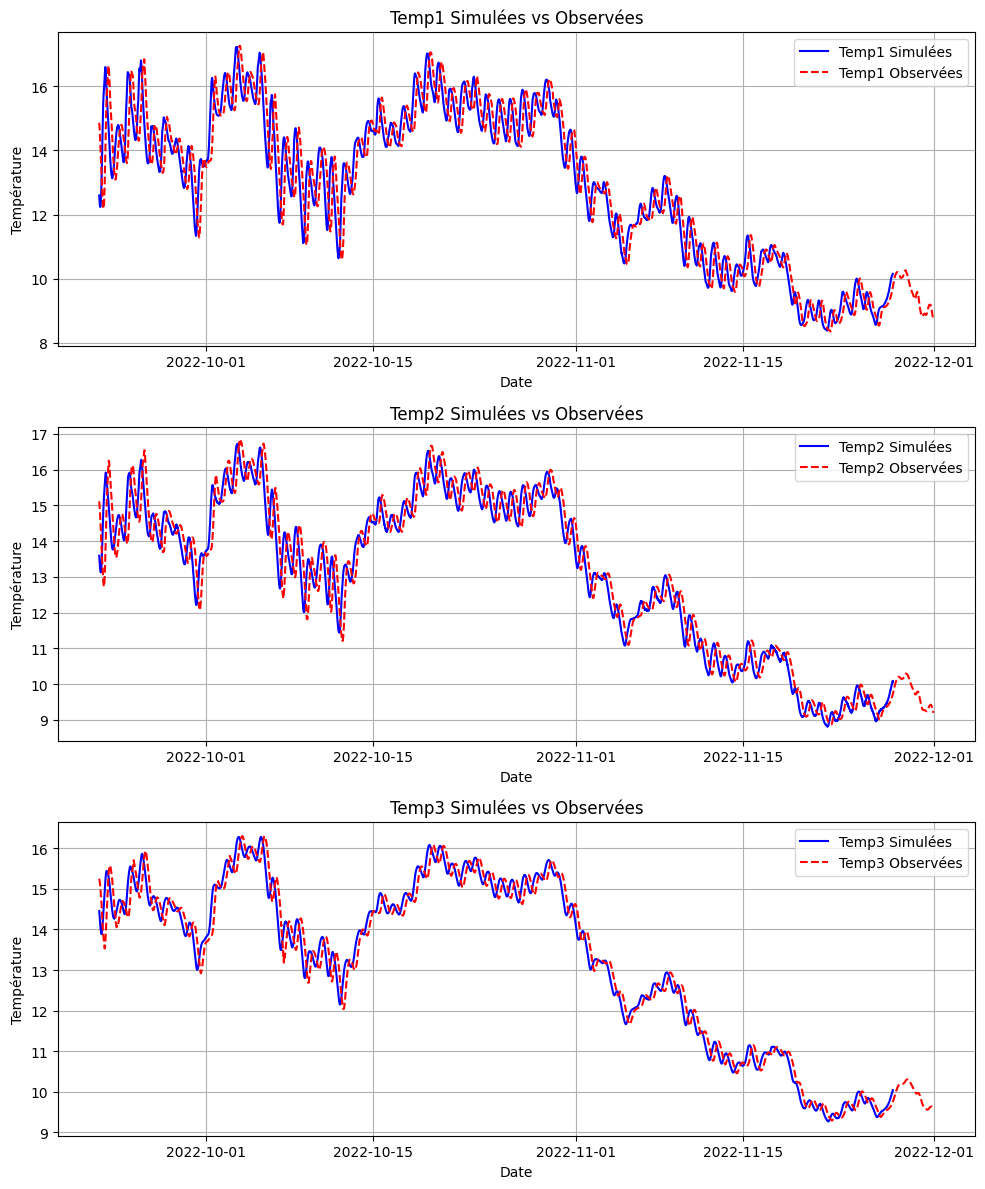

In [50]:
obs_temp = all_data[(all_data['dates'] > '2022-09-22')&(all_data['dates'] < '2022-12-01')]
sim_temp_z = sim_temp[(sim_temp['dates'] > '2022-09-22') & (sim_temp['dates'] < '2022-12-01')]

# Tracer les températures simulées et observées pour chaque température
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Tracer les températures simulées (sim_temp)
for i in range(1, 4):
    axs[i - 1].plot(sim_temp_z['dates'], sim_temp_z[f'Temp{i}'], label=f'Temp{i} Simulées', linestyle='-', color='blue')

# Tracer les températures observées (sim_obs)
for i in range(1, 4):
    axs[i - 1].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], label=f'Temp{i} Observées', linestyle='--', color='red')

    # Configurations supplémentairobes pour chaque subplot
    axs[i - 1].set_xlabel('Date')
    axs[i - 1].set_ylabel('Température')
    axs[i - 1].set_title(f'Temp{i} Simulées vs Observées')
    axs[i - 1].legend()
    axs[i - 1].grid(True)

# Afficher les subplots
plt.tight_layout()

# Save the plot to a file (e.g., PNG format)
plt.savefig('my_plot.png')
plt.show()

In [51]:
# Fusionner les DataFrames en fonction des dates communes
merged_data = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
merged_data = merged_data.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'
})

merged_data

,dates,VMolo,deltaP,TempMolo,Temp1_obs,Temp2_obs,Temp3_obs,Temp4,bot,top,Temp1_sim,Temp2_sim,Temp3_sim,Time
0,2022-09-22 00:15:00,1.04672,-0.176069,14.051,14.861,15.112,15.252,15.281,0,0.176069,12.598570,13.592775,14.454110,12392100.0
1,2022-09-22 00:30:00,1.05172,-0.171033,14.013,14.806,15.067,15.236,15.281,0,0.171033,12.521243,13.532240,14.409169,12393000.0
2,2022-09-22 00:45:00,1.05397,-0.170962,14.974,14.746,15.024,15.220,15.282,0,0.170962,12.447650,13.471059,14.364419,12393900.0
3,2022-09-22 01:00:00,1.05938,-0.165518,14.935,14.679,14.973,15.197,15.281,0,0.165518,12.383198,13.410954,14.319515,12394800.0
4,2022-09-22 01:15:00,1.06209,-0.162748,14.896,14.607,14.927,15.176,15.279,0,0.162748,12.329169,13.353771,14.274683,12395700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,2022-11-27 13:00:00,0.90553,-0.306053,9.685,9.643,9.663,9.717,9.888,0,0.306053,10.114416,10.039035,9.993991,18140400.0
6388,2022-11-27 13:15:00,0.90473,-0.306910,9.714,9.666,9.675,9.725,9.892,0,0.306910,10.119711,10.041898,10.002987,18141300.0
6389,2022-11-27 13:30:00,0.90099,-0.310671,9.740,9.689,9.689,9.731,9.897,0,0.310671,10.130349,10.074324,10.018778,18142200.0
6390,2022-11-27 13:45:00,0.89985,-0.311862,9.768,9.712,9.701,9.738,9.901,0,0.311862,10.138374,10.063200,10.026815,18143100.0


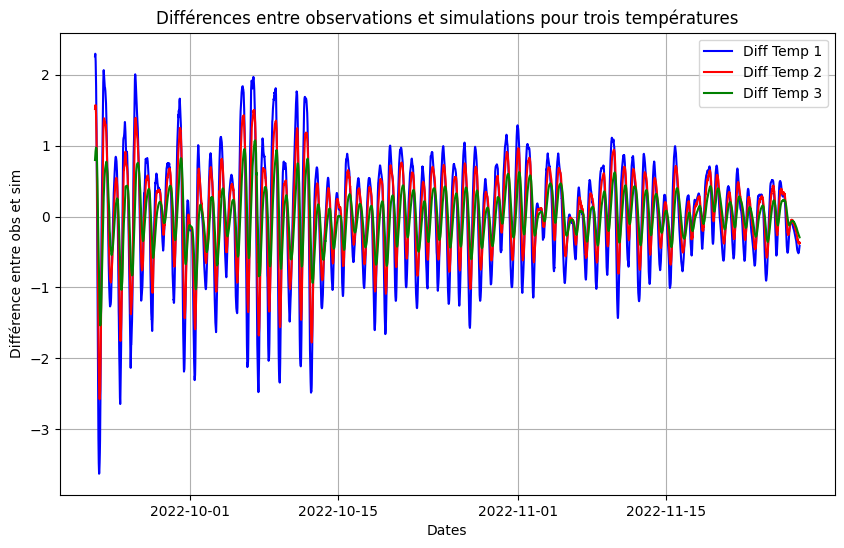

In [52]:
# Calculer les différences entre les températures simulées et observées
merged_data['Diff_Temp1'] = merged_data['Temp1_obs'] - merged_data['Temp1_sim']
merged_data['Diff_Temp2'] = merged_data['Temp2_obs'] - merged_data['Temp2_sim']
merged_data['Diff_Temp3'] = merged_data['Temp3_obs'] - merged_data['Temp3_sim']



# Création du graphique
plt.figure(figsize=(10, 6))

plt.plot(merged_data['dates'], merged_data['Diff_Temp1'], label='Diff Temp 1', color='blue')
plt.plot(merged_data['dates'], merged_data['Diff_Temp2'], label='Diff Temp 2', color='red')
plt.plot(merged_data['dates'], merged_data['Diff_Temp3'], label='Diff Temp 3', color='green')

plt.xlabel('Dates')
plt.ylabel('Différence entre obs et sim')
plt.title('Différences entre observations et simulations pour trois températures')
plt.legend()
plt.grid(True)

plt.show()


In [53]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff_sensor = f'Diff_Temp{i}'

        diff = data[diff_sensor]
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics

# Appel de la fonction pour calculer les métriques pour chaque capteur
metrics_dict = calculate_metrics(merged_data)

# Affichage des résultats
for sensor, metrics in metrics_dict.items():
    print(f"Métriques pour {sensor}:")
    print(f"RMSE: {metrics['RMSE']}")
    print(f"MAE: {metrics['MAE']}")
    print(f"PBias: {metrics['PBias']}")
    print(f"KGE: {metrics['KGE']}")
    print()


Métriques pour Temp1:
RMSE: 0.829312564870454
MAE: 0.6543435049182414
PBias: 0.061858684823396355
KGE: 0.35321674052726704

Métriques pour Temp2:
RMSE: 0.5827582134995779
MAE: 0.46012550565014476
PBias: 0.2989082617259626
KGE: 0.26584234973178045

Métriques pour Temp3:
RMSE: 0.34863541771767953
MAE: 0.27077841207384035
PBias: 0.04614164256667919
KGE: 0.17160117900132077



# Flux eau

In [54]:
flux_eau=pd.read_csv('Sim_velocity_profil_t.dat',sep='\s+',header=None)
flux_eau = flux_eau.rename(columns={0: 'Time', 1: 'z', 2: 'v'})
flux_eau

,Time,z,v
0,900.0,-0.105,-6.689192e-09
1,900.0,-0.115,-6.689382e-09
2,900.0,-0.125,-6.689698e-09
3,900.0,-0.135,-6.690139e-09
4,900.0,-0.145,-6.690708e-09
...,...,...,...
604795,18144000.0,-0.355,-1.187758e-07
604796,18144000.0,-0.365,-1.185010e-07
604797,18144000.0,-0.375,-1.183122e-07
604798,18144000.0,-0.385,-1.182019e-07


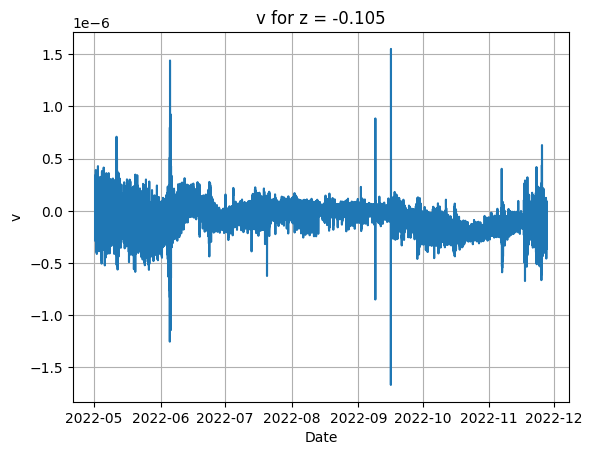

In [55]:
flux_eau['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(flux_eau['Time'], unit='s')

selected_data = flux_eau[flux_eau['z'] == -0.105]
plt.plot(selected_data['dates'], selected_data['v'])
plt.xlabel('Date')
plt.ylabel('v')
plt.title('v for z = -0.105')
plt.grid(True)
plt.show()


## 2. Screening parmeters
### 2.1 Range definition


In [56]:
 # zone 1
    # porosity
REF_n=0.10 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
REF_k=-12
    # Heat capacity
REF_r=2500
    #lambda
REF_l=3
    # zone 2
    # porosity
REF_n2=0.05 # \omega
    # intrinsic permeability [m2]  k=K*mu/(rho*g)
REF_k2=-14
    # solid grain density rho_s=val_r  [kg.m-3]
REF_r2=2600
REF_l2=3

In [57]:
dvt_k = 1 
#dvt_n = 0.1
dvt_l=1
#dvt_c=100


range_k = [REF_k-dvt_k,REF_k+dvt_k]
range_k2 = [REF_k2-dvt_k,REF_k2+dvt_k]
#range_n =  [REF_n-dvt_n,REF_n+dvt_n]
#range_c =  [REF_c-dvt_c,REF_c+dvt_c]
range_l =  [REF_l-dvt_l,REF_l+dvt_l]
range_l2 =  [REF_l2-dvt_l,REF_l2+dvt_l]

if (range_l[0] < 0.8):
    range_l[0] = 0.8
if (range_l2[0] < 0.8):
    range_l2[0] = 0.8
    
print(range_l,range_l2,range_k,range_k2)

[2, 4] [2, 4] [-13, -11] [-15, -13]


### 2.2 Paramétrisation

Choice of step values for each of the parameters, the measurement error and the number of sample. The following values are proposed as a first intention, they can be modified if necessary.

### 2.3 loop table param
Later, you will use a loop of i over param_all


### 2.5 Misfit function

In [58]:
def rmse(predictions, ref,sigma):
    differences = ((predictions - ref)/sigma)                      #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val

### 2.6 loops of simulations

One you're sure all steps work correctly, you will uncoment the loop over the whole table of parameters. Replace all row_1 by df

In [60]:

import pandas as pd
import numpy as np
import itertools

# Assuming you have defined REF_k, REF_k2, REF_l, REF_l2, dvt_k, i_k, range_k, range_k2, range_l, range_l2 somewhere in your code.

parameter_table = pd.DataFrame()
param_all = ["k", "k2", 'l', 'l2']
param = ["l", "l2","k", "k2"]

for i in param:
    for x in param_all:
        if x != i:
            if 'k' in x:
                # Specify the desired 'k' values
                k_values = np.linspace(range_k[0], range_k[1], i_k)
                k_values = np.power(10, k_values)
                # Format values in scientific notation for 'k' columns
                value_k = k_values
            if 'k2' in x:
                k_values = np.linspace(range_k2[0], range_k2[1], i_k)
                k_values = np.power(10, k_values)
                value_k2 = k_values
            if 'l' in x:
                l_values = np.linspace(range_l[0], range_l[1], i_l)
                value_l = l_values
            if 'l2' in x:    
                l_values = np.linspace(range_l2[0], range_l2[1], i_l2)
                value_l2 = l_values
                



# Generate all possible combinations of parameter values
parameter_combinations = list(itertools.product(value_k, value_k2, value_l, value_l2))

# Convert the list to a pandas DataFrame
parameter_table = pd.DataFrame(parameter_combinations, columns=['k', 'k2', 'l', 'l2'])

# Display the parameter table
print(parameter_table)





NameError: name 'i_k' is not defined

In [45]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff = data[f'{sensor}_sim'] - data[f'{sensor}_obs']
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics



In [46]:
criteria = pd.DataFrame(columns=['k','k2','l','l2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])

for i in parameter_table.index:
    print(i)
    criteria_i = pd.DataFrame(columns=['k','k2','l','l2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    REF_k = parameter_table.loc[i, 'k']
    REF_k2 = parameter_table.loc[i, 'k2']
    REF_l = parameter_table.loc[i, 'l']
    REF_l2 = parameter_table.loc[i, 'l2']
    print(REF_k, REF_k2, REF_l, REF_l2)
    criteria_i['k'] = [REF_k]
    criteria_i['k2'] = [REF_k2]
    criteria_i['l'] = [REF_l]
    criteria_i['l2'] = [REF_l2]
    # write the setup of the parameter zone file
    # read E_zone_parameter.dat
    f_paramZ_new = open("E_zone_parameter.dat", 'w')
    # read E_zone_parameter_backup.dat
    f_paramZ_bck = open("E_zone_parameter_backup.dat", "r")
    # replace the parameter values
    param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
    param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
    param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
    param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
    # FILEPATH: /home/ariviere/Programmes/ginette/application/mini-LOMOS/grid_search_ginette_2PTT.ipynb
    if nb_zone == 2:
        f_param_bck.close()
        f_paramZ_bck = open("E_zone_parameter_backup_2zones.dat", "r")
        param_zone = f_paramZ_bck.read()
        param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
        param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
        param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
        param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
        param_zone = param_zone.replace('[k2]', '%8.2e' % REF_k2)
        param_zone = param_zone.replace('[n2]', '%6.2f' % REF_n2)
        param_zone = param_zone.replace('[l2]', '%6.2f' % REF_l2)
        param_zone = param_zone.replace('[r2]', '%6.2f' % REF_r2)

    f_paramZ_new.write(param_zone)
    f_paramZ_new.close()
    f_paramZ_bck.close()

    # run ginette
    subprocess.call(["./ginette"])

    # save the results
    # Colonnes pour les températures
    column_names = ['Temp_1', 'Temp_2', 'Temp_3']

    # Liste pour stocker les DataFrames
    all_dfs = []
    # Lire et stocker les DataFrames
    for i in range(1, 4):
        file_path = f'Sim_temperature_maille{i}_t.dat'
        df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
        all_dfs.append(df)

    # Fusionner les DataFrames sur la colonne 'Time'
    sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

    for df in all_dfs[1:]:
        sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

    # Trier les colonnes par ordre numérique
    sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
    sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

    # save files with parameters in the name files
    filename = "Ref_k_{}_Ref_k2_{}_Ref_l_{}_Ref_l2_{}.csv".format(REF_k, REF_k2, REF_l, REF_l2)
    sim_temp.to_csv(filename, index=False)
    # Fusionner les DataFrames en fonction des dates communes
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
  
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
    metrics_dict = calculate_metrics(obs_sim)
    # Affichage des résultats
    # Loop through each sensor and save the metrics to the dataframe
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']
            
  # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True)
        

# Save the dataframe to a CSV file
criteria.to_csv('simulation_results.csv', index=False)

0
1e-13 1e-15 2.0 2.0


/tmp/ipykernel_132317/1669066655.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  criteria=pd.concat([criteria,criteria_i],ignore_index=True)


1
1e-13 1e-15 2.0 2.6666666666666665
2
1e-13 1e-15 2.0 3.333333333333333
3
1e-13 1e-15 2.0 4.0
4
1e-13 1e-15 2.6666666666666665 2.0
5
1e-13 1e-15 2.6666666666666665 2.6666666666666665
6
1e-13 1e-15 2.6666666666666665 3.333333333333333
7
1e-13 1e-15 2.6666666666666665 4.0
8
1e-13 1e-15 3.333333333333333 2.0
9
1e-13 1e-15 3.333333333333333 2.6666666666666665
10
1e-13 1e-15 3.333333333333333 3.333333333333333
11
1e-13 1e-15 3.333333333333333 4.0
12
1e-13 1e-15 4.0 2.0
13
1e-13 1e-15 4.0 2.6666666666666665
14
1e-13 1e-15 4.0 3.333333333333333
15
1e-13 1e-15 4.0 4.0
16
1e-13 4.641588833612772e-15 2.0 2.0
17
1e-13 4.641588833612772e-15 2.0 2.6666666666666665
18
1e-13 4.641588833612772e-15 2.0 3.333333333333333
19
1e-13 4.641588833612772e-15 2.0 4.0
20
1e-13 4.641588833612772e-15 2.6666666666666665 2.0
21
1e-13 4.641588833612772e-15 2.6666666666666665 2.6666666666666665
22
1e-13 4.641588833612772e-15 2.6666666666666665 3.333333333333333
23
1e-13 4.641588833612772e-15 2.6666666666666665 4.0
24

In [47]:

obs_temp

,dates,VMolo,deltaP,TempMolo,Temp1,Temp2,Temp3,Temp4,bot,top
2022-09-22 00:15:00,2022-09-22 00:15:00,1.04672,-0.176069,14.051,14.861,15.112,15.252,15.281,0,0.176069
2022-09-22 00:30:00,2022-09-22 00:30:00,1.05172,-0.171033,14.013,14.806,15.067,15.236,15.281,0,0.171033
2022-09-22 00:45:00,2022-09-22 00:45:00,1.05397,-0.170962,14.974,14.746,15.024,15.220,15.282,0,0.170962
2022-09-22 01:00:00,2022-09-22 01:00:00,1.05938,-0.165518,14.935,14.679,14.973,15.197,15.281,0,0.165518
2022-09-22 01:15:00,2022-09-22 01:15:00,1.06209,-0.162748,14.896,14.607,14.927,15.176,15.279,0,0.162748
...,...,...,...,...,...,...,...,...,...,...
2022-11-30 22:45:00,2022-11-30 22:45:00,1.03913,-0.171281,8.567,8.785,9.256,9.586,9.875,0,0.171281
2022-11-30 23:00:00,2022-11-30 23:00:00,1.04439,-0.166017,8.542,8.765,9.242,9.578,9.872,0,0.166017
2022-11-30 23:15:00,2022-11-30 23:15:00,1.05160,-0.158812,8.512,8.742,9.228,9.572,9.868,0,0.158812
2022-11-30 23:30:00,2022-11-30 23:30:00,1.04439,-0.165869,8.476,8.717,9.214,9.564,9.864,0,0.165869


In [48]:
# trouver tous les fichiers csv débutant avec    Ref_k
import glob
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
criteria=pd.DataFrame(columns=['k','k2','l','l2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
# find file with Ref_k
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv = [f for f in files_csv if 'Ref_k' in f]
print(files_csv)
    
df_test=pd.read_csv(files_csv[0])
df_test['dates'] = pd.to_datetime(df_test['dates'])
print(df_test.head())
obs_sim = pd.merge(obs_temp, df_test, on='dates', how='inner')
obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
metrics_dict = calculate_metrics(obs_sim)

['Ref_k_1e-10_Ref_k2_4.6415888336127725e-12_Ref_l_4.0_Ref_l2_2.0.csv', 'Ref_k_1e-09_Ref_k2_2.1544346900318867e-10_Ref_l_4.0_Ref_l2_4.0.csv', 'Ref_k_1e-15_Ref_k2_4.6415888336127915e-17_Ref_l_9.333333333333332_Ref_l2_0.8.csv', 'Ref_k_2.1544346900318867e-10_Ref_k2_1e-11_Ref_l_4.666666666666667_Ref_l2_4.0.csv', 'Ref_k_2.1544346900318779e-10_Ref_k2_2.1544346900318778e-14_Ref_l_6.666666666666666_Ref_l2_0.8.csv', 'Ref_k_1e-14_Ref_k2_1e-14_Ref_l_2.0_Ref_l2_6.0.csv', 'Ref_k_1e-14_Ref_k2_1e-14_Ref_l_8.0_Ref_l2_6.0.csv', 'Ref_k_1e-11_Ref_k2_4.641588833612773e-11_Ref_l_6.0_Ref_l2_5.333333333333333.csv', 'Ref_k_1e-13_Ref_k2_2.1544346900318866e-14_Ref_l_4.0_Ref_l2_4.0.csv', 'Ref_k_1e-07_Ref_k2_2.1544346900318778e-14_Ref_l_12.0_Ref_l2_0.8.csv', 'Ref_k_1e-10_Ref_k2_1e-14_Ref_l_8.0_Ref_l2_2.0.csv', 'Ref_k_2.1544346900318779e-10_Ref_k2_1e-19_Ref_l_4.0_Ref_l2_4.933333333333334.csv', 'Ref_k_2.1544346900318868e-12_Ref_k2_4.641588833612772e-15_Ref_l_3.333333333333333_Ref_l2_2.6666666666666665.csv', 'Ref_k_1

In [49]:

# Create a list of dataframes with the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the name
dfs = []

for file in files_csv:
    obs_sim = pd.DataFrame()
    df = pd.read_csv(file)
    # add the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the dataframe
    df['Ref_k'] = file.split('_')[2]
    df['Ref_k2'] = file.split('_')[5]
    df['Ref_l'] = file.split('_')[8]
    df['Ref_l2'] = file.split('_')[11]
    # remove .csv fro df['Ref_l2]
    df['Ref_l2'] = df['Ref_l2'].str.replace('.csv', '')
    df['Ref_k'] = df['Ref_k'].astype(float)
    df['Ref_k2'] = df['Ref_k2'].astype(float)
    df['Ref_l'] = df['Ref_l'].astype(float)
    df['Ref_l2'] = df['Ref_l2'].astype(float)
    # calculate crietria
    df['dates']= pd.to_datetime(df['dates'])
    sim_temp = df
    
    criteria_i=pd.DataFrame(columns=['k','k2','l','l2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    criteria_i['k'] = [df['Ref_k'][0]]
    criteria_i['k2'] = [df['Ref_k2'][0]]
    criteria_i['l'] = [df['Ref_l'][0]]
    criteria_i['l2'] = [df['Ref_l2'][0]]
    # Loop through each sensor and save the metrics to the dataframe
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
  
    metrics_dict = calculate_metrics(obs_sim)
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']


    # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True) 


/tmp/ipykernel_132317/966040755.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  criteria=pd.concat([criteria,criteria_i],ignore_index=True)


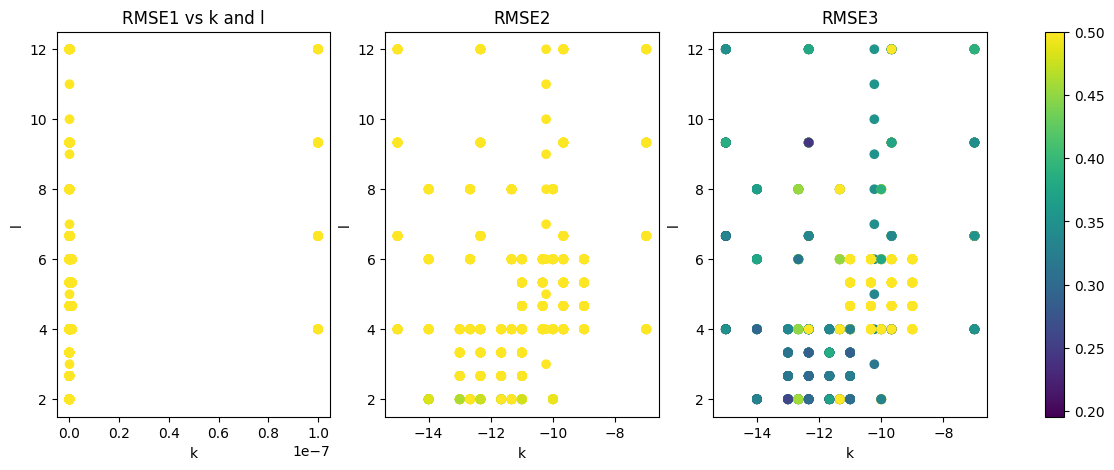

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of RMSE1, RMSE2, and RMSE3
min_rmse = min(criteria[['RMSE1', 'RMSE2', 'RMSE3']].min())
#max_rmse = max(criteria[['RMSE1', 'RMSE2', 'RMSE3']].max())
max_rmse = 0.5
# Create a normalization instance
norm = Normalize(vmin=min_rmse, vmax=max_rmse)

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter((criteria['k']), criteria['l'], c=criteria['RMSE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k')
axs[0].set_ylabel('l')
axs[0].set_title('RMSE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['RMSE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k')
axs[1].set_ylabel('l')
axs[1].set_title('RMSE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['RMSE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k')
axs[2].set_ylabel('l')
axs[2].set_title('RMSE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()


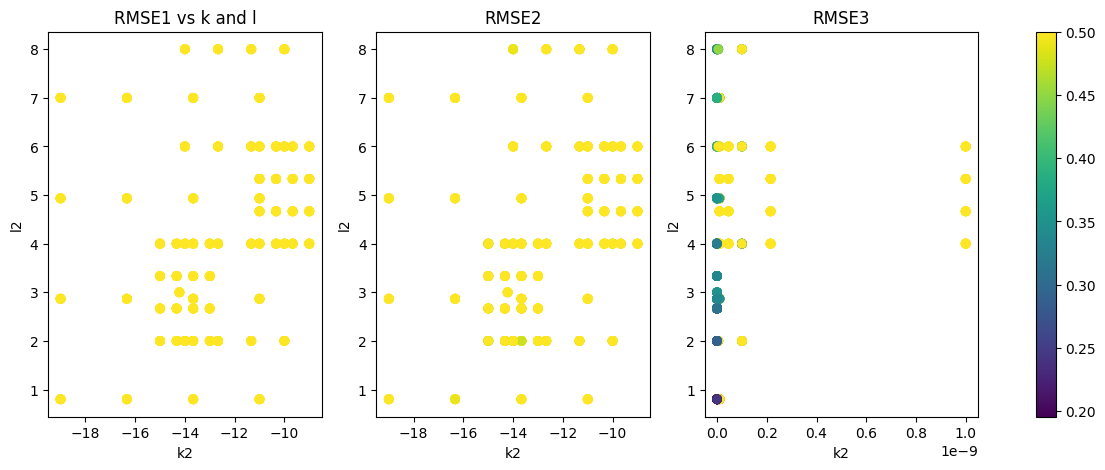

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of RMSE1, RMSE2, and RMSE3
min_rmse = min(criteria[['RMSE1', 'RMSE2', 'RMSE3']].min())
#max_rmse = max(criteria[['RMSE1', 'RMSE2', 'RMSE3']].max())
max_rmse = 0.5
# Create a normalization instance
norm = Normalize(vmin=min_rmse, vmax=max_rmse)

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['RMSE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k2')
axs[0].set_ylabel('l2')
axs[0].set_title('RMSE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['RMSE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k2')
axs[1].set_ylabel('l2')
axs[1].set_title('RMSE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter((criteria['k2']), criteria['l2'], c=criteria['RMSE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k2')
axs[2].set_ylabel('l2')
axs[2].set_title('RMSE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()


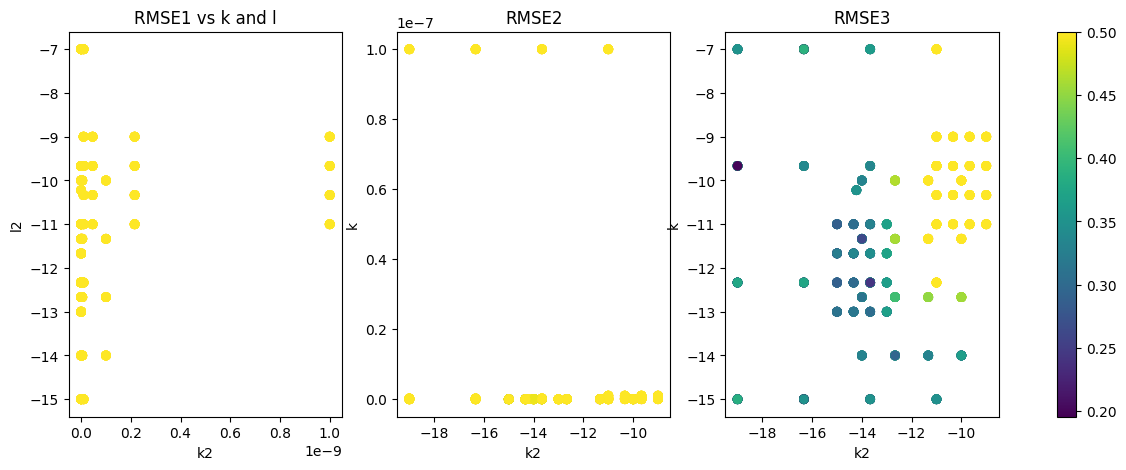

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter((criteria['k2']), np.log10(criteria['k']), c=criteria['RMSE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k2')
axs[0].set_ylabel('l2')
axs[0].set_title('RMSE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['k'], c=criteria['RMSE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k2')
axs[1].set_ylabel('k')
axs[1].set_title('RMSE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter(np.log10(criteria['k2']), np.log10(criteria['k']), c=criteria['RMSE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k2')
axs[2].set_ylabel('k')
axs[2].set_title('RMSE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()

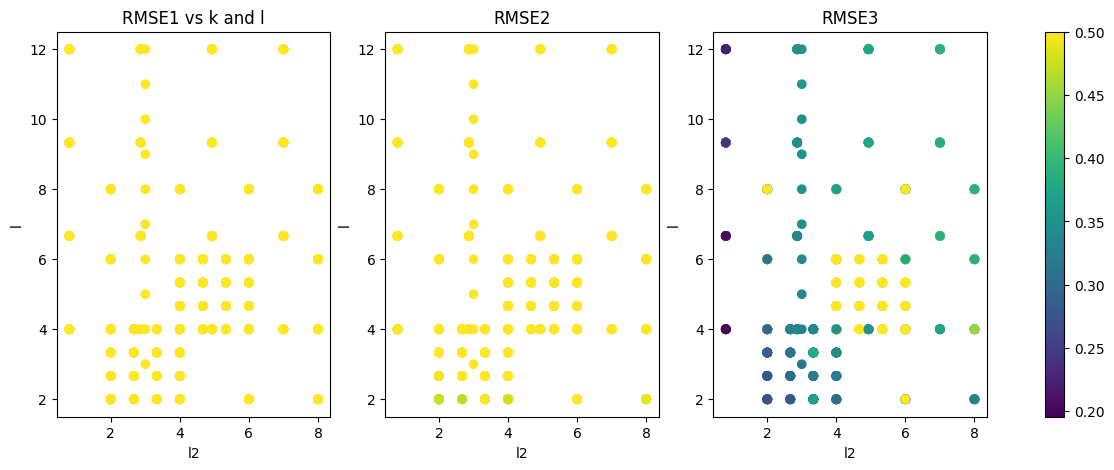

In [53]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter((criteria['l2']), (criteria['l']), c=criteria['RMSE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('l2')
axs[0].set_ylabel('l')
axs[0].set_title('RMSE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter((criteria['l2']), criteria['l'], c=criteria['RMSE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('l2')
axs[1].set_ylabel('l')
axs[1].set_title('RMSE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter((criteria['l2']), (criteria['l']), c=criteria['RMSE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('l2')
axs[2].set_ylabel('l')
axs[2].set_title('RMSE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()

In [54]:
criteria.head(1)

,k,k2,l,l2,RMSE1,MAE1,PBias1,KGE1,RMSE2,MAE2,PBias2,KGE2,RMSE3,MAE3,PBias3,KGE3
0,1.000000e-10,4.641589e-12,4.0,2.0,0.843822,0.666289,-0.118255,0.35939,0.874631,0.691916,-1.351529,0.394312,0.939819,0.73796,-2.170151,0.439337


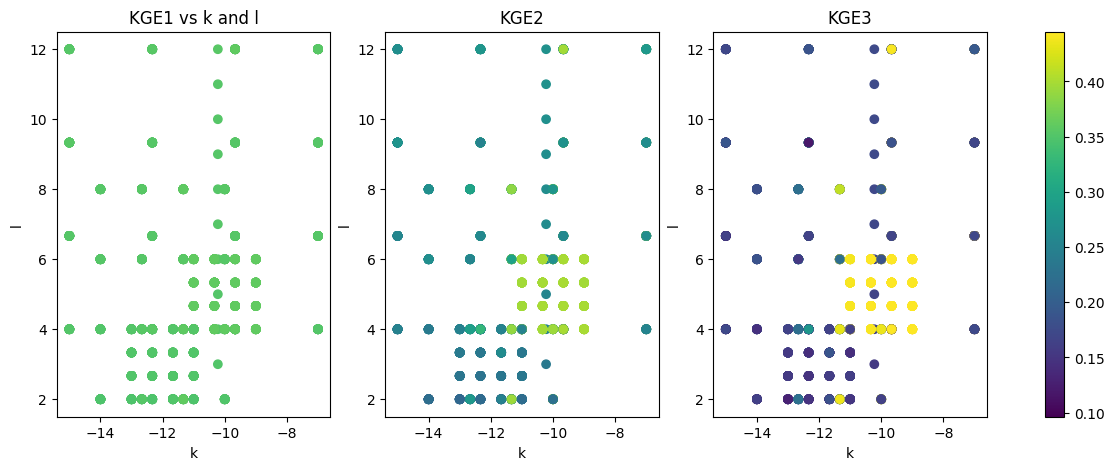

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of RMSE1, RMSE2, and RMSE3
min_rmse = min(criteria[['KGE1', 'KGE2', 'KGE3']].min())
max_rmse = max(criteria[['KGE1', 'KGE2', 'KGE3']].max())

# Create a normalization instance
norm = Normalize(vmin=min_rmse, vmax=max_rmse)

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k')
axs[0].set_ylabel('l')
axs[0].set_title('KGE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k')
axs[1].set_ylabel('l')
axs[1].set_title('KGE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k')
axs[2].set_ylabel('l')
axs[2].set_title('KGE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()


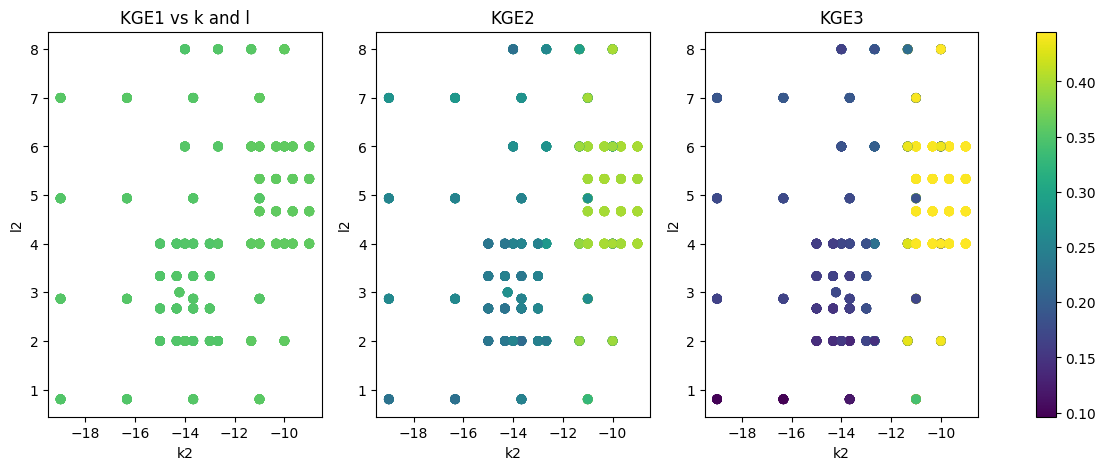

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of RMSE1, RMSE2, and RMSE3
min_rmse = min(criteria[['KGE1', 'KGE2', 'KGE3']].min())
max_rmse = max(criteria[['KGE1', 'KGE2', 'KGE3']].max())

# Create a normalization instance
norm = Normalize(vmin=min_rmse, vmax=max_rmse)

# Tracer RMSE 1 plot log scale for k and l
scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
axs[0].set_xlabel('k2')
axs[0].set_ylabel('l2')
axs[0].set_title('KGE1 vs k and l')

# Tracer RMSE 2
scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
axs[1].set_xlabel('k2')
axs[1].set_ylabel('l2')
axs[1].set_title('KGE2')

# Tracer RMSE 3
scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
axs[2].set_xlabel('k2')
axs[2].set_ylabel('l2')
axs[2].set_title('KGE3')

# Create a single colorbar using the first scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()
